# Polycystic Ovary Syndrome (PCOS) Detection with CNN

## **Introduction**  

Polycystic Ovary Syndrome (PCOS) is a common hormonal disorder that affects women of reproductive age. It is characterized by irregular menstrual cycles, elevated levels of male hormones (androgens), and the presence of multiple small follicles in the ovaries, often leading to infertility and metabolic complications.
Traditional diagnostic methods for PCOS rely on **ultrasound imaging** and hormone level assessments. However, manual interpretation of ultrasound images is time-consuming and prone to human error. Recent advancements in **Deep Learning** have enabled the automation of medical image analysis, improving diagnostic accuracy and efficiency.  

- This project aims to develop a **Convolutional Neural Network (CNN)-based model** to classify ovarian ultrasound images into **PCOS-infected** and **non-infected (healthy) ovaries**.

---
- The dataset for this project is sourced from **[Kaggle](https://www.kaggle.com/datasets/anaghachoudhari/pcos-detection-using-ultrasound-images/data.)**
- It consists of 'train' and 'test' subfolders containing ultrasound images organized into **‘infected’** (PCOS-diagnosed ovaries) and **‘notinfected’** (healthy ovaries) categories.  

## 1. Import Necessary Libraries

In [58]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

# TensorFlow & Keras: Used for deep learning model development.  
# ImageDataGenerator: Helps preprocess and augment image data.  
# Matplotlib & NumPy: Used for visualization and numerical operations.

## 2. Load and Preprocess Data

#### Define File Paths 

In [100]:
train_dir = r"C:\Users\pc\Desktop\B-older\Data and Stuff\GMC\ML GMC\Dami\pcos_train"
test_dir = r"C:\Users\pc\Desktop\B-older\Data and Stuff\GMC\ML GMC\Dami\pcos_test"

# The dataset is structured with ‘infected’ and ‘notinfected’ subfolders inside `train` and `test` directories.

In [101]:
def verify_and_fix_images(data_dir):
    """
    Verify and remove corrupted images from the dataset directory.

    Args:
        data_dir (str): Path to the directory containing image data.
    """

    # Walk through all files and subdirectories in the given directory
    for root, _, files in os.walk(data_dir):
        for file in files:
            file_path = os.path.join(root, file)  # Get the full path of the file
            try:
                # Attempt to open the image using Pillow (PIL)
                img = Image.open(file_path)
                
                # Verify the image format by converting it to grayscale ('L')
                img.convert('L')
                
                # Close the image file after verification to free resources
                img.close()
            
            except (IOError, OSError) as e:
                # Print an error message if the image cannot be opened or processed
                print(f"Error with file: {file_path}. Error: {e}")
                
                # Remove the corrupted image file to avoid issues during training
                os.remove(file_path)
                print(f"Removed corrupted image: {file_path}")

# Call the function before creating the data generators to ensure all images are valid
verify_and_fix_images(train_dir)
verify_and_fix_images(test_dir)

Error with file: C:\Users\pc\Desktop\B-older\Data and Stuff\GMC\ML GMC\Dami\pcos_test\infected\OIP.jpg. Error: cannot identify image file 'C:\\Users\\pc\\Desktop\\B-older\\Data and Stuff\\GMC\\ML GMC\\Dami\\pcos_test\\infected\\OIP.jpg'
Removed corrupted image: C:\Users\pc\Desktop\B-older\Data and Stuff\GMC\ML GMC\Dami\pcos_test\infected\OIP.jpg
Error with file: C:\Users\pc\Desktop\B-older\Data and Stuff\GMC\ML GMC\Dami\pcos_test\infected\R.jpg. Error: cannot identify image file 'C:\\Users\\pc\\Desktop\\B-older\\Data and Stuff\\GMC\\ML GMC\\Dami\\pcos_test\\infected\\R.jpg'
Removed corrupted image: C:\Users\pc\Desktop\B-older\Data and Stuff\GMC\ML GMC\Dami\pcos_test\infected\R.jpg
Error with file: C:\Users\pc\Desktop\B-older\Data and Stuff\GMC\ML GMC\Dami\pcos_test\infected\WhatsApp Image 2022-04-01 at 3.49.22 PM.jpeg. Error: cannot identify image file 'C:\\Users\\pc\\Desktop\\B-older\\Data and Stuff\\GMC\\ML GMC\\Dami\\pcos_test\\infected\\WhatsApp Image 2022-04-01 at 3.49.22 PM.jpeg'

#### Image Preprocessing and Augmentation

In [102]:
img_size = (224, 224)  # Resize images for CNN input
batch_size = 64 # Without batch processing the model would try to load all images at once into memory. This could cause RAM overload and system crashes.

train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values (0-255 → 0-1)
    rotation_range= 15,  # Random rotation up to 20 degrees
    width_shift_range=0.2,  # Random horizontal shifting
    height_shift_range=0.2,  # Random vertical shifting
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Random zooming
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest'  # Fill missing pixels after transformations
)

test_datagen = ImageDataGenerator(rescale=1.0/255)  # Only normalization, no augmentation

train_generator = train_datagen.flow_from_directory( # Loads images from folders
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    color_mode ='grayscale',
    class_mode='binary',  # PCOS classification is binary (infected/not infected)
    shuffle = True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    color_mode ='grayscale',
    class_mode='binary',
    shuffle = False
)

Found 1924 images belonging to 2 classes.
Found 1922 images belonging to 2 classes.


#### Visualize original and augmented images from the training dataset.

In [105]:
print("Train classes:", train_generator.class_indices)
print("Test classes:", test_generator.class_indices)

Train classes: {'infected': 0, 'notinfected': 1}
Test classes: {'infected': 0, 'notinfected': 1}


In [103]:
# Get a batch of images
images, labels = next(train_generator)
print("shape of images", images.shape)
print("shape of labels:", labels.shape)

shape of images (64, 224, 224, 1)
shape of labels: (64,)


In [104]:
print("Labels:", labels[:10])  # Print first 10 labels
print("Unique labels:", np.unique(labels))

Labels: [1. 1. 1. 0. 0. 0. 1. 0. 1. 0.]
Unique labels: [0. 1.]


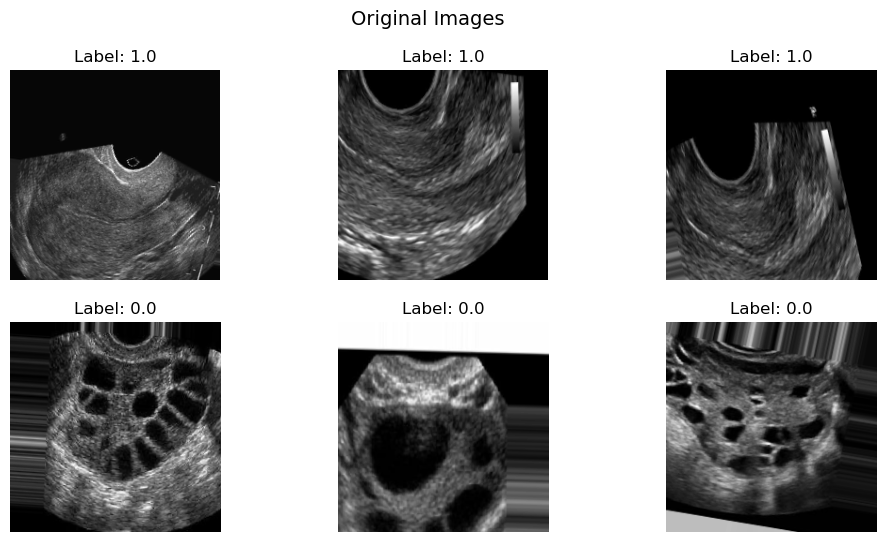

In [106]:
# Note that
# next() retrieves the next item from an iterator.
# In the context of train_generator, it retrieves the next batch of images and labels.
# In the context of augmented_images, it retrieves the next batch of augmented images. 
# The number of images will be as defined in the batch_size parameter.

# Function to plot original images
def plot_images(images, title, num=6):
    plt.figure(figsize=(12, 6))
    for i in range(num):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].squeeze(), cmap="gray")
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.suptitle(title, fontsize=14)
    plt.show()

# Show original images
plot_images(images, title="Original Images")

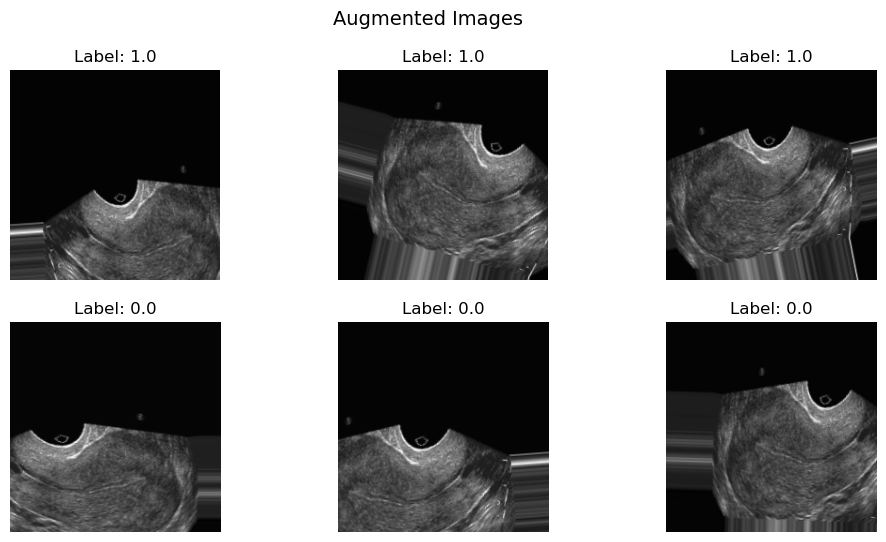

In [107]:
# Generate augmented images from the first image in batch
augmented_images = train_datagen.flow(np.expand_dims(images[0], axis=0), batch_size=5)

# Show augmented images
augmented_batch = [next(augmented_images)[0] for _ in range(6)]
plot_images(augmented_batch, title="Augmented Images")

**Why Image Augmentation?**
- Without data augmentation, the model sees the same images repeatedly and may memorize them instead of learning general patterns.
- For example, if the model has only seen upright images of ovaries, it might struggle to classify an ultrasound taken at a slightly different angle.
- In real-life medical scans, ultrasound images may be: rotated slightly, shifted due to patient movement, zoomed in or out, taken at different brightness levels, have slight distortions. etc.
- If these variations are not simulated during training, the model will fail when encountering such differences in test data.



**How to choose the values to use for image augmentation in the ImageDataGenerator function**
- Basically, these values **are not fixed**—they **should be tuned** based on:
  1. **Dataset size** (More data → Less augmentation needed)
  2. **Image type** (Medical images need **subtle augmentations**)
  3. **Domain knowledge** (Check if flipping, shearing, etc., affect medical interpretation)
- **Best practice:**  
  - Start with conservative augmentations.
  - Experiment and validate using test/validation data.
  - Use `matplotlib` to **visualize augmented images** before training.

| Parameter | Default Value | Recommended for Medical Images? | Notes |
|-----------|--------------|--------------------------------|-------|
| `rescale` | `1./255` | ✅ **Yes** (Mandatory) | Standard for CNNs |
| `rotation_range` | `20` | ✅ **Lower (~5-15°)** | Too much rotation may distort medical images |
| `width_shift_range` | `0.2` | ✅ **Lower (~0.1)** | Helps with misalignment |
| `height_shift_range` | `0.2` | ✅ **Lower (~0.1)** | Helps with misalignment |
| `shear_range` | `0.2` | ⚠️ **Use cautiously (~0.1 or disable)** | Shearing can distort features |
| `zoom_range` | `0.2` | ✅ **Lower (~0.1)** | Prevents excessive cropping |
| `horizontal_flip` | `True` | ⚠️ **Check dataset** | May not be suitable for all medical images |
| `fill_mode` | `'nearest'` | ✅ **Yes** | Keeps images realistic |

## 3. Build the CNN Model

In [108]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),  # First Convolutional Layer
    layers.MaxPooling2D((2, 2)),  # First Max-Pooling Layer
    
    layers.Conv2D(64, (3, 3), activation='relu'),  # Second Convolutional Layer
    layers.MaxPooling2D((2, 2)),  # Second Max-Pooling Layer

    layers.Conv2D(128, (3, 3), activation='relu'),  # Third Convolutional Layer
    layers.MaxPooling2D((2, 2)),  # Third Max-Pooling Layer

    layers.Conv2D(256, (3, 3), activation='relu'),  # Fourth Convolutional Layer
    layers.MaxPooling2D((2, 2)),  # Fourth Max-Pooling Layer
    
    layers.Flatten(),  # Flatten feature maps to 1D
    layers.Dense(128, activation='relu'),  # Fully connected layer
    layers.Dropout(0.5),  # Dropout to prevent overfitting
    layers.Dense(1, activation='sigmoid')  # Output layer (Binary Classification)
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


# - Conv2D Layers: Extracts patterns from images using different filters.  
# - MaxPooling: Reduces image size while retaining key features.  
# - Flatten Layer: Converts the 2D output into a 1D vector.  
# - Dense Layers: Fully connected layers that classify images.  
# - Dropout: Reduces overfitting.  
# - Sigmoid Activation: Outputs probabilities for binary classification.

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)                   │ (None, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │       4,718,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,106,689 (19.48 MB)

 Trainable params: 5,106,689 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Train the Model

In [110]:
epochs = 5  # Number of times the model goes through the dataset.
stepsPerEpoch = int(np.ceil(train_generator.samples / batch_size))
validationSteps = int(np.ceil(test_generator.samples / batch_size))

#Early stopping
stopEarly = EarlyStopping(monitor = 'val_accuracy', patience = 5)

In [111]:
history = model.fit(
    train_generator,
    validation_data = test_generator, # Helps track model performance on unseen images.
    steps_per_epoch = stepsPerEpoch,
    epochs = epochs,
    validation_steps = validationSteps, 
    callbacks = [stopEarly]
)

Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - accuracy: 0.6127 - loss: 0.6616 - val_accuracy: 0.9995 - val_loss: 0.0396
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.9698 - loss: 0.1037 - val_accuracy: 1.0000 - val_loss: 0.0120
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.9910 - loss: 0.0279 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.9927 - loss: 0.0238 - val_accuracy: 1.0000 - val_loss: 9.7677e-05
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.9986 - loss: 0.0061 - val_accuracy: 1.0000 - val_loss: 4.1679e-04


## 5. Evaluate the Model

In [112]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 700ms/step - accuracy: 1.0000 - loss: 2.0721e-04
Test Accuracy: 1.00


## 6. Model Performance Analysis

#### Plot Training & Validation Accuracy/Loss

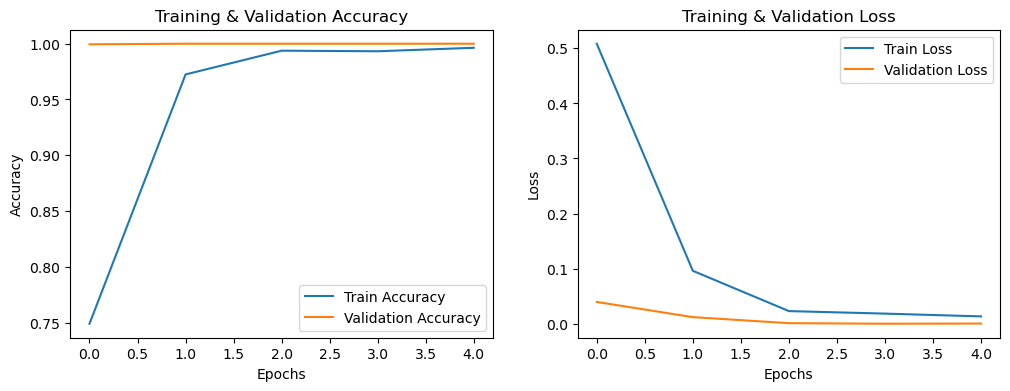

In [113]:
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

#### Confusion Matrix & Classification Report

31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 833ms/step


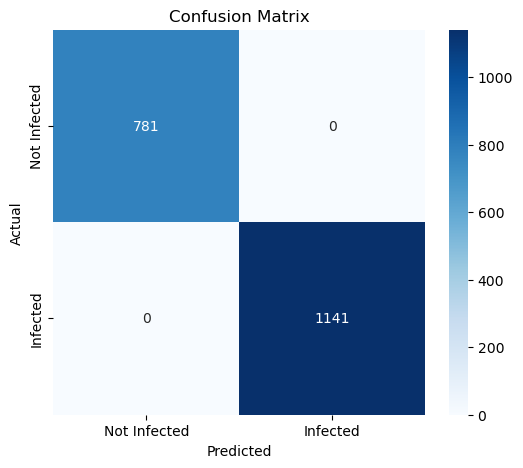

In [114]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict labels for test data
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred = np.where(y_pred > 0.5, 1, 0)  # Convert probabilities to binary labels

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred) # Show model performance in terms of TP, FP, TN, FN.  
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Infected', 'Infected'], yticklabels=['Not Infected', 'Infected'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [115]:
# Classification Report
print(classification_report(y_true, y_pred, target_names=['Not Infected', 'Infected'])) # Gives precision, recall, and F1-score.

              precision    recall  f1-score   support

Not Infected       1.00      1.00      1.00       781
    Infected       1.00      1.00      1.00      1141

    accuracy                           1.00      1922
   macro avg       1.00      1.00      1.00      1922
weighted avg       1.00      1.00      1.00      1922



#### Display model predictions

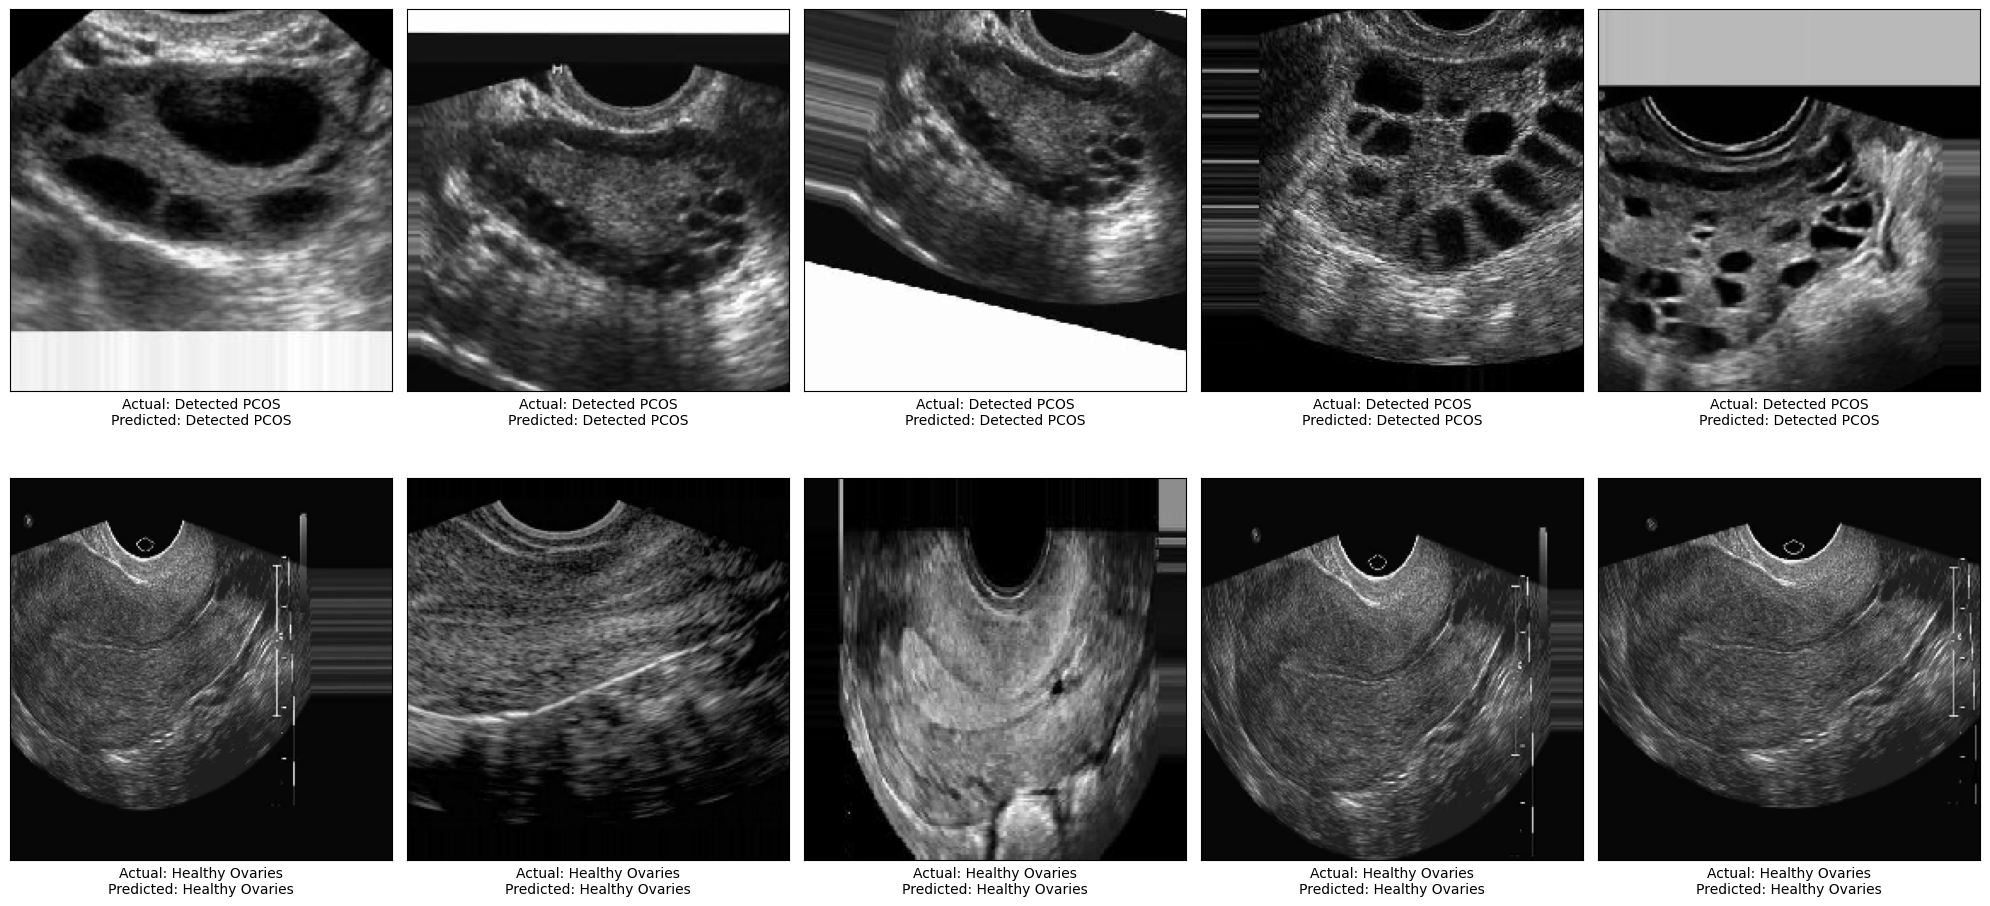

In [117]:
# Define target names for display
target_names = ['Detected PCOS', 'Healthy Ovaries']

# Load all images and labels from the generator
all_images = []
all_labels = []

# Iterate over the entire test data generator to gather all images and labels
for batch_images, batch_labels in test_generator:
    all_images.append(batch_images)
    all_labels.append(batch_labels)
    if len(all_images) * test_generator.batch_size >= len(test_generator.classes):  # Stop after all images are collected
        break

# Convert the lists to arrays
all_images = np.vstack(all_images)
all_labels = np.hstack(all_labels)

# Generate predicted labels from your model predictions
predicted_labels = (y_pred > 0.5).astype(int).flatten()

# Ensure we get images from both classes
healthy_indices = np.where(all_labels == 0)[0]  # Indices for 'Healthy Ovaries'
pcos_indices = np.where(all_labels == 1)[0]  # Indices for 'Detected PCOS'

# Randomly select 5 healthy and 5 PCOS images for display
selected_indices = np.concatenate([
    np.random.choice(healthy_indices, 5, replace=False),
    np.random.choice(pcos_indices, 5, replace=False)
])

# Fetching the selected images and their labels
plt.figure(figsize=(20, 10))  # Adjust the width for better display of 5 images
for i, img_index in enumerate(selected_indices):
    plt.subplot(2, 5, i + 1)  # 2 row and 5 columns
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Access the image and true label
    image = all_images[img_index]  # Get the image
    actual_label = all_labels[img_index]  # True label
    predicted_label = predicted_labels[img_index]  # Predicted label

    # Display the image
    plt.imshow(image.squeeze(), cmap='gray')  # Display grayscale image

    # Ensure actual_label and predicted_label are integers for indexing
    plt.xlabel(f"Actual: {target_names[int(actual_label)]}\nPredicted: {target_names[int(predicted_label)]}")

# Show the plot
plt.tight_layout()
plt.show()

## 7. Save & Load Model for Deployment

In [118]:
# Save Model
model.save("pcos_detection_model.h5")

In [ ]:
# Load Model for Inference
loaded_model = keras.models.load_model("pcos_detection_model.h5") # Allows reusing the trained model for future predictions.

## 8. Test on New Ultrasound Images

In [ ]:
from tensorflow.keras.preprocessing import image

def predict_pcos(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize
    prediction = model.predict(img_array)[0][0]
    
    if prediction > 0.5:
        print("PCOS Detected")
    else:
        print("Normal Ovary")

# Example usage
predict_pcos("sample_ultrasound.jpg", loaded_model)

## 9. Deployment on Streamlit
 Build an interactive UI for users to upload ultrasound images.

In [129]:
code_content = '''
# Import necessary libraries
import streamlit as st
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image

# Set the title of the app
st.title("PCOS Detection Using Ultrasound Images")

# Add a description
st.write("""
This app uses a Convolutional Neural Network (CNN) to classify ultrasound images of ovaries as **PCOS-infected** or **healthy**.
Upload an ultrasound image, and the app will predict whether the ovary is affected by PCOS.
""")

# Load the pre-trained model
@st.cache_resource  # Cache the model to avoid reloading on every interaction
def load_pcos_model():
    model = load_model(r"C:\\Users\\pc\Desktop\\B-older\\Data and Stuff\\GMC\ML GMC\\Dami\\pcos_detection_model.h5")  # Load the saved model
    return model

model = load_pcos_model()

# Function to preprocess the image
def preprocess_image(image):
    # Resize the image to match the model's input size (224x224)
    image = image.resize((224, 224))
    # Convert the image to grayscale (1 channel)
    image = image.convert("L")  # "L" mode converts the image to grayscale
    # Convert the image to a numpy array
    image_array = np.array(image)
    # Normalize the image (scale pixel values to [0, 1])
    image_array = image_array / 255.0
    # Add a batch dimension (model expects input shape (batch_size, 224, 224, 3))
    image_array = np.expand_dims(image_array, axis=0)
    return image_array

# Function to make predictions
def predict(image):
    # Preprocess the image
    processed_image = preprocess_image(image)
    # Make a prediction using the model
    prediction = model.predict(processed_image)
    # Get the prediction probability
    probability = prediction[0][0]
    # Convert the prediction to a class label
    if prediction[0] > 0.5:
        label =  "Healthy"
    else:
        label =  "PCOS-infected"
    # Return both the label and probability
    return label, probability

# File uploader for the user to upload an image
uploaded_file = st.file_uploader("Upload an ultrasound image", type=["jpg", "jpeg", "png"])

# If an image is uploaded, display it and make a prediction
if uploaded_file is not None:
    # Open the uploaded image
    image = Image.open(uploaded_file)
    # Display the image
    st.image(image, caption="Uploaded Image", use_column_width=True)
    # Make a prediction
    st.write("Classifying...")
    label, probability = predict(image)
    # Display the result with color coding
    if label == "Healthy":
        st.success(f"Prediction: **{label}** (Confidence: {probability:.2f})")
    else:
        st.error(f"Prediction: **{label}** (Confidence: {1 - probability:.2f})")
'''

# Open a .py file in write mode and save the code content in it.
with open('pcos_detection_streamlit_app.py', 'w') as file:
    file.write(code_content)

print("The Python script has been successfully saved to 'pcos_detection_app.py'")

The Python script has been successfully saved to 'pcos_detection_app.py'


<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\pc\AppData\Local\Temp\ipykernel_14112\288403481.py:1: SyntaxWarning: invalid escape sequence '\D'
  code_content = '''
